# Getting started with QStone

## Introduction

In this tutorial, you will epxlore how to use QStone to benchmark and profile different quantum compuations. It will cover the the following steps:

1. **Scheduler and job generation**: Generate the scripts to run the scheduler with jobs defined by an input configuration.
2. **Running the scheduler**: Running the computations on the scheduling platform of your choice.
3. **Profiling and analysis**: Measuring metrics of the different computations and identifying bottenecks.



## Prerequisites

Follow the installation instructions in the detailed in the repostiry readme.md

# Generation

## Input configuration

First you need to create an input json configuration to describe your  the configuration of your QPU, the type connector you have to interface with your QPU and a list detailing the different users you want to benchmark and the jobs they are interested in running.

In the exampple configuration below have defined a QPU requiring 55 qubits on a local NO_LINK connections. We have also defined 3 users 2 uses with different weights (the weight affections the number of jobs generated for each user). Each user has descrived a pdf of the the jobs they are interested in running. In the example the 3 jobs the users are interested in running are:
**type0**: A VQE type computation.
**type1**: Randomized benchmarking computation.
**type2**: Error correction surface code computation.

```
{
    "project_name" : "proj_name",     
    "connector" : "NO_LINK",
    "qpu_ip_address" : "0.0.0.0",
    "qpu_port" : "55",
    "num_required_qubits" : 100,
    "users" : [
        {
        "user": "user0",
        "weight" : 0.2,
        "computations" : 
            {
            "type0": 0.05,
            "type1": 0.94,
            "type2": 0.01
            }
        },
        {
        "user": "user1",
        "weight" : 0.3,
        "computations" : 
             {
             "type0": 0.10,
             "type1": 0.85,
             "type2": 0.05
             }
        }
   ]
}
```

Now on your CLI run the **generate** command 

    `qstone generate -i conf.json`

Generates tar.gz files that contains all the scripts to run scheduler for each user. Currently supported schedulers: [baremetal, altair/fnc, slurm/schedmd]

# Running the scheduler

Now use the **run** command to execute on your chosen scheduler and user.

    `qstone run -i bare_metal_user0.qstone.tar.gz`


## Profiling
Once you have ran the schedulers for the users you are intrested in, you can compile this information using the **profile** command to save it a hdf5 file.

    ```qstone profile --cfg conf.json --folder qstone_profile```


## Analytics

We can now read our hdf5 file and develop your own comparisons and analytics.
### Loading the hdf5 file

In [185]:
import pandas as pd

df = pd.read_hdf("QS_Profile.h5")
df["time_taken"] = df["end"] - df["start"]

In [186]:
df

,user,prog_id,job_id,job_type,job_step,start,end,total,pre_agg,run_agg,post_agg,time_taken
0,user1,1,13,TYPE2,RUN,13460072658379251,13460072710011170,51631919,0.0,0.0,0.0,51631919
0,user1,1,12,CONNECTION,POST,13460060887193711,13460060888921568,1727857,0.0,0.0,0.0,1727857
0,user1,1,2,TYPE1,PRE,13459881534780579,13459892049466139,10514685560,0.0,0.0,0.0,10514685560
0,user1,1,6,TYPE2,PRE,13459964471381621,13459964478582371,7200750,0.0,0.0,0.0,7200750
0,user1,1,29,CONNECTION,PRE,13460378819630543,13460378820157964,527421,0.0,0.0,0.0,527421
...,...,...,...,...,...,...,...,...,...,...,...,...
0,user1,1,0,TYPE1,POST,13459852536962882,13459852544902136,7939254,0.0,0.0,0.0,7939254
0,user1,1,15,TYPE1,PRE,13460094970156969,13460105298817098,10328660129,0.0,0.0,0.0,10328660129
0,user1,1,0,CONNECTION,QUERY,13459832584482124,13459832597590432,13108308,0.0,0.0,0.0,13108308
0,user1,1,22,CONNECTION,PRE,13460237528697072,13460237529295670,598598,0.0,0.0,0.0,598598


### Visualising the profiler

We can plot the distriubtion of the different job types.

In [187]:
import matplotlib.pyplot as plt
import numpy as np


# Helper function for generating bar charts.
def create_bar_chart(data, title, xlabel, ylabel):
    colors = plt.cm.viridis(np.linspace(0, 1, len(data)))
    data.plot(kind="bar", color=colors)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

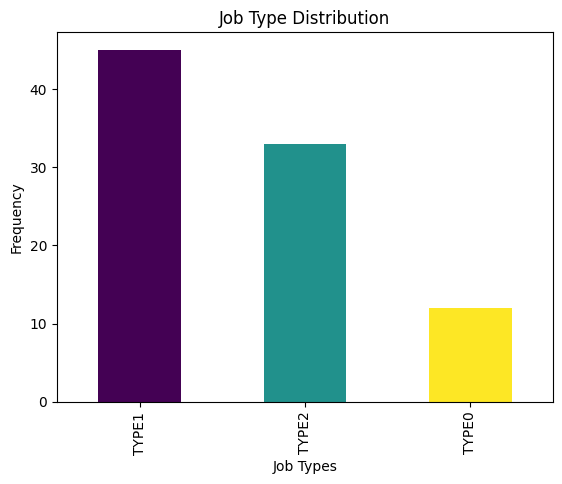

In [188]:
comp_df = df.loc[df["job_type"] != "CONNECTION"]

job_type_counts = comp_df["job_type"].value_counts()
job_step_counts = comp_df["job_step"].value_counts()

create_bar_chart(job_type_counts, "Job Type Distribution", "Job Types", "Frequency")

We can also plot the total time spent per job type.

In [189]:
def calculate_total_time(x):
    total_time = x["time_taken"].sum()
    return total_time


type_run_time = comp_df.groupby("job_type").apply(calculate_total_time)

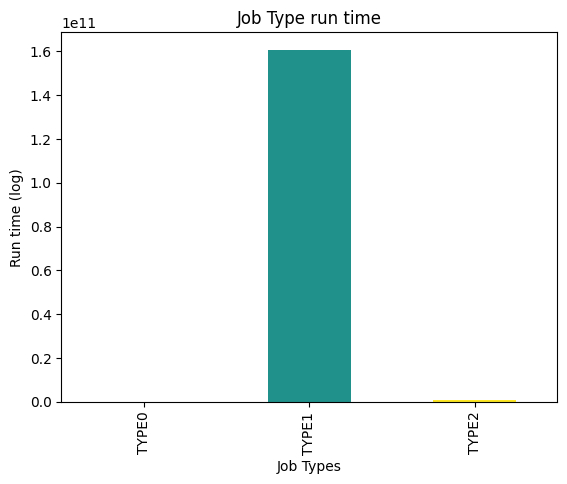

In [190]:
create_bar_chart(type_run_time, "Job Type run time", "Job Types", "Run time (log)")

As you can see the majority of the time is spent on the type1 Randomized Benchmarking computation. We can also plot the log of the run time to better see the run times of the other computations.

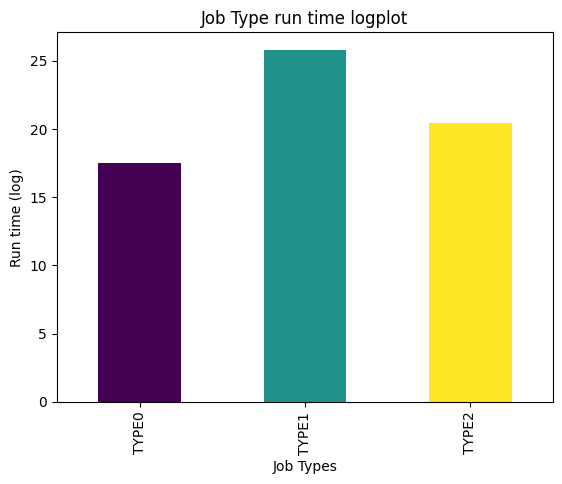

In [191]:
def total_time_log(x):
    total_time = np.log(x["time_taken"].sum())
    return total_time


log_type_run_time = comp_df.groupby("job_type").apply(total_time_log)
create_bar_chart(
    log_type_run_time, "Job Type run time logplot", "Job Types", "Run time (log)"
)